In [1]:
from ipfx_new.ipfx_new.x_to_nwb import ABFConverter
ABFConverter.ABFConverter('examples/2020_08_28_0005.abf', 'output/2020_08_28_0005.nwb', includeChannelList=['0'])

C:\Users\Allose\Documents\GitHub\ABF2_NWB\ipfx_new\ipfx_new\x_to_nwb\ABFConverter.py:154: UserWarning: Could not find the JSON file examples/2020_08_28_0005.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")
C:\Users\Allose\Documents\GitHub\ABF2_NWB\ipfx_new\ipfx_new\x_to_nwb\ABFConverter.py:466: UserWarning: Could not find the scale factor for the stimset I-V curve ,-400 pA, using 1.0 as fallback.
  warnings.warn(f"Could not find the scale factor for the stimset {stimset}, using {DEFAULT_SCALE_FACTOR} as fallback.")
C:\Users\Allose\Documents\GitHub\ABF2_NWB\ipfx_new\ipfx_new\x_to_nwb\ABFConverter.py:493: UserWarning: Could not find settings for amplifier unknown of channel 0.
  warnings.warn(f"Could not find settings for amplifier {amplifier} of channel {adcName}.")


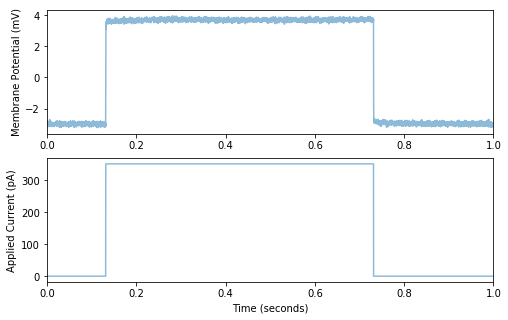

In [14]:
### Import statements
import pyabf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# refers to example_datasets folder in github repo
file_rel_path = 'examples/'

curr_file = '2020_08_28_0005.abf'
abf_file_path = file_rel_path + curr_file

abf = pyabf.ABF(abf_file_path) # this is the basic function for accessing abf files

### Configuration variables
stim_channel_num = 0 # on which channel number is the stimulus?
response_chan_num = 0 # on which channel number is the response?

stim_gain = 1 # integer gain on stimulus
response_gain = 1 # integer gain on response

stim_end = 1 # time point where stimulus ends

sweep_plot_list = [15] # sweeps we want to plot
fig = plt.figure(figsize=(8, 5))

### Figure plotting
for i in sweep_plot_list:
    sweep_num = i
    
    # this setSweep command sets the currently active sweep in the file
    abf.setSweep(sweep_num, channel=response_chan_num)
    # plot the ADC (voltage recording)
    ax1 = fig.add_subplot(211)
    ax1.plot(abf.sweepX, abf.sweepY*response_gain, alpha = .5)

    # plot the DAC (clamp current)
    abf.setSweep(sweep_num, channel=stim_channel_num)
    ax2 = fig.add_subplot(212, sharex=ax1)  
    #abf.setSweep(sweep_num, channel=1)
    ax2.plot(abf.sweepX, abf.sweepC * stim_gain, alpha = .5)

# decorate the plots
ax1.set_ylabel(abf.sweepLabelY)
ax2.set_xlabel(abf.sweepLabelX)
ax2.set_ylabel(abf.sweepLabelC)
ax1.axes.set_xlim(0, stim_end)  # <-- adjust axis like this
plt.show()

In [3]:
# Load IPFX libraries
from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps
from ipfx.qc_feature_extractor import sweep_qc_features

# Load pandas library too
import pandas as pd
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps

file_name = "output/2020_08_28_0005.nwb"

# Create Ephys Data Set

print('loading dataset into data structure...')
#nwb_file_name = '/Users/stripathy/Downloads/sub-601462951_ses-601810292_icephys.nwb'
data_set = create_ephys_data_set(nwb_file=file_name, ontology="ipfx/ipfx/defaults/stimulus_ontology.json") ##loads nwb file into ipfx data structure

# sweep = data_set.sweep(0)
# sweep_features = sweep_qc_features(data_set)
# Drop failed sweeps: sweeps with incomplete recording or failing QC criteria
drop_failed_sweeps(data_set)
# ipfx.data_set_features.extract_data_set_features(data_set, subthresh_min_amp=None)[source]


loading dataset into data structure...


In [5]:
from ipfx.feature_extractor import SpikeFeatureExtractor, SpikeTrainFeatureExtractor

import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch
import matplotlib.pyplot as plt


# get sweep table of Long Square sweeps
long_square_table = data_set.filtered_sweep_table(
    stimuli=data_set.ontology.long_square_names
)
long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)

long_square_sweeps = data_set.sweep_set()

# Select epoch corresponding to the actual recording from the sweeps
# and align sweeps so that the experiment would start at the same time
long_square_sweeps.select_epoch("recording")
#long_square_sweeps.align_to_start_of_epoch("experiment")

# find the start and end time of the stimulus
# (treating the first sweep as representative)
stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0], test_pulse=False)
stim_start_time = long_square_sweeps.t[0][stim_start_index]
stim_end_time = long_square_sweeps.t[0][stim_end_index]

stim_start_time = 0.1
stim_end_time = 0.8

# build the extractors
spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time)

# run the analysis and print out a few of the features
long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0, require_subthreshold=False, require_suprathreshold=False)
data = long_square_analysis.analyze(long_square_sweeps)

fields_to_print = [
    'v_baseline',
    'vm_for_sag',
    'sag'
]

for field in fields_to_print:
    print("%s: %s" % (field, str(data[field])))

INFO:root:No spiking long square sweeps: cannot compute related cell features.


v_baseline: -3.033073055744171
vm_for_sag: -10.589601
sag: 0.9926139116287231
